# Awesome spectral indices

Notebook aimed to explore the Awesome spectral indices package.

The Awesome Spectral Indices is a standardized ready-to-use curated list of spectral indices that can be used as expressions for computing spectral indices in remote sensing applications. The list was born initially to supply spectral indices for Google Earth Engine through eemont and spectral, but given the necessity to compute spectral indices for other object classes outside the Earth Engine ecosystem, a new package was required.

Spyndex is a python package that uses the spectral indices from the Awesome Spectral Indices list and creates an expression evaluation method that is compatible with python object classes that support overloaded operators (e.g. numpy.ndarray, pandas.Series, xarray.DataArray).
 
* Documentation:  [paper](awesome_spectral_indices.pdf) 

* Python package: [spyndex](https://github.com/awesome-spectral-indices/spyndex)

* Indices list: [list](https://github.com/awesome-spectral-indices/awesome-spectral-indices)

In [351]:
import spyndex

## Exploring Spectral indices

First of all, we can get all the available indices in the package. The package has an exhaustive and complete list of spectral indices, with a total of 231 indices and the capability to compute them.

In [352]:
print(spyndex.indices)
print(len(spyndex.indices))

['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CCI', 'CIG', 'CIRE', 'CSI', 'CSIT', 'CVI', 'DBI', 'DBSI', 'DPDD', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'DpRVIHH', 'DpRVIVV', 'EBBI', 'EMBI', 'EVI', 'EVI2', 'ExG', 'ExGR', 'ExR', 'FCVI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MuWIR', 'NBAI', 'NBLI', 'NBLIOLI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRT1', 'NBRT2', 'NBRT3', 'NBRplus', 'NBSIMS', 'NBUI', 'ND705', 'NDBI', 'NDBaI', 'NDCI', 'NDDI', 'NDGI', 'NDGlaI', 'NDII', 'NDISIb', 'NDISIg'

If we want, we can search for an specific index by its name, obtaining several information about the index:
* Application Domain (vegetation, soil, urban...)
* Bands needed as parameters
* Index formula
* Index reference, as a link to a paper.

In [353]:
print(spyndex.indices.NDVI)

NDVI: Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        


Moreover, we can get specific information about the inde, like the formula or the reference.

In [354]:
print(spyndex.indices.NDVI.formula)

(N-R)/(N+R)


In [355]:
print(spyndex.indices.NDVI.reference)

https://ntrs.nasa.gov/citations/19740022614


## Computation

We are going to compute some spectral indices, in order to have an idea of the kind of things that the package could provide. In that way, we want to integrate the spyndex package with the [Sentinel Hub Python interface](https://sentinelhub-py.readthedocs.io/en/latest/index.html), using the `sentinelhub` package to download Sentinel data.

In [356]:
from os import getenv

from sentinelhub import (SHConfig, 
                        DataCollection, 
                        SentinelHubCatalog, 
                        SentinelHubRequest, 
                        bbox_to_dimensions,
                        MimeType, 
                        BBox,
                        CRS, 
                        SentinelHubDownloadClient)

from dotenv import load_dotenv   

load_dotenv()   # Load the Sentinel Hub credentials from .env

config = SHConfig()
config.sh_client_id = getenv('sh_client_id')
config.sh_client_secret = getenv('sh_client_secret')
config.save()

### Vegetation indices

In this use case, we will compute some vegetation indices:
* DVI
* NDVI
* GNDVI
* SAVI

The area of interest is Santa Fe del Montseny, in the [Montseny Natural Park](https://es.wikipedia.org/wiki/Parque_natural_del_Montseny).

In [357]:
%%time

time = ('2023-01-01', '2023-01-10')
bounding_box = BBox((2.441115, 41.755421, 2.492793, 41.789093), crs=CRS.WGS84)   # Santa Fe del Montseny

evalscript = """
    //VERSION=3

function setup() {
    return {
    input:  [{
                bands: ["B03","B04","B08"],
                units: "DN"
            }],
    output: { 
        bands: 3, 
        sampleType: "INT16"
        }
    }
}

function evaluatePixel(sample) {
    return [sample.B03, sample.B04, sample.B08]
}
"""

!rm -r data

request = SentinelHubRequest(
        data_folder='data',
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bounding_box,
        size=bbox_to_dimensions(bounding_box, 5),
        config=config
        )

image = request.get_data(save_data=True)[0]
image.shape

CPU times: user 49.3 ms, sys: 27.7 ms, total: 77.1 ms
Wall time: 3.28 s


(742, 864, 3)

Arriving to this point, we can decide which approach we want to follow to compute the index. In this use case we will repeat the same process following the `rioxarray` approach, using `xarray.DataArray`, and the `rasterio` approach, using `np.array`. In the following use case we will only follow the `rioxarray` approach.

#### Rioxarray

<xarray.DataArray (y: 742, x: 864)>
array([[0.1692, 0.1692, 0.2052, ..., 0.1608, 0.1608, 0.1198],
       [0.1692, 0.1692, 0.2052, ..., 0.2035, 0.2035, 0.1718],
       [0.0851, 0.0851, 0.1288, ..., 0.2035, 0.2035, 0.1718],
       ...,
       [0.1072, 0.1072, 0.114 , ..., 0.222 , 0.222 , 0.2081],
       [0.0793, 0.0793, 0.1078, ..., 0.222 , 0.222 , 0.2081],
       [0.0793, 0.0793, 0.1078, ..., 0.184 , 0.184 , 0.1953]])
Coordinates:
  * x        (x) float64 2.441 2.441 2.441 2.441 ... 2.493 2.493 2.493 2.493
  * y        (y) float64 41.79 41.79 41.79 41.79 ... 41.76 41.76 41.76 41.76
    index    <U5 'DVI'


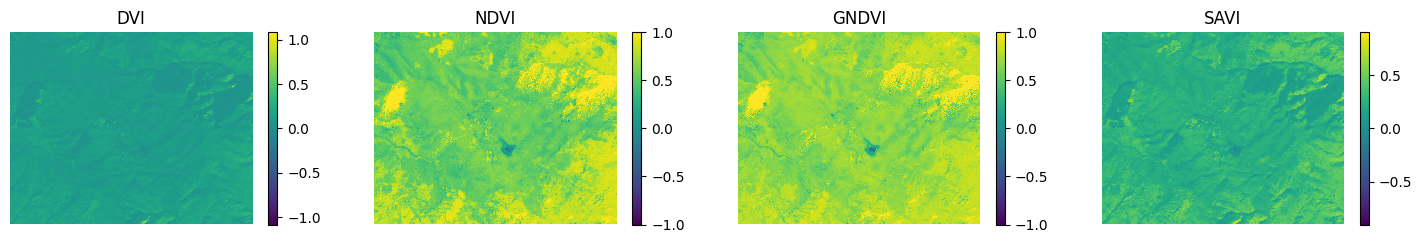

In [358]:
import spyndex 
import rioxarray
from glob import glob

tiff = glob('data/*/response.tiff')[0]

ds = rioxarray.open_rasterio(tiff)

# Scale the data (remember that the valid domain for reflectance is [0,1])
ds = ds / 10000

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = ["DVI", "NDVI", "GNDVI", "SAVI"],
    params = {
        "N": ds.sel(band = 3),
        "R": ds.sel(band = 2),
        "G": ds.sel(band = 1),
        "L": 0.5
    }
)

# Plot the indices
fig, ax = plt.subplots(1, 4, figsize = (18,2.5))

idx.sel(index = "DVI").plot(ax = ax[0], cmap='viridis')
ax[0].set_axis_off()
ax[0].set_title('DVI')

idx.sel(index = "NDVI").plot(ax = ax[1], cmap='viridis')
ax[1].set_axis_off()
ax[1].set_title('NDVI')

idx.sel(index = "GNDVI").plot(ax = ax[2], cmap='viridis')
ax[2].set_axis_off()
ax[2].set_title('GNDVI')

idx.sel(index = "SAVI").plot(ax = ax[3], cmap='viridis')
ax[3].set_axis_off()
ax[3].set_title('SAVI')

print(idx.sel(index = "DVI"))

#### Rasterio

[[0.1692 0.1692 0.2052 ... 0.1608 0.1608 0.1198]
 [0.1692 0.1692 0.2052 ... 0.2035 0.2035 0.1718]
 [0.0851 0.0851 0.1288 ... 0.2035 0.2035 0.1718]
 ...
 [0.1072 0.1072 0.114  ... 0.222  0.222  0.2081]
 [0.0793 0.0793 0.1078 ... 0.222  0.222  0.2081]
 [0.0793 0.0793 0.1078 ... 0.184  0.184  0.1953]]


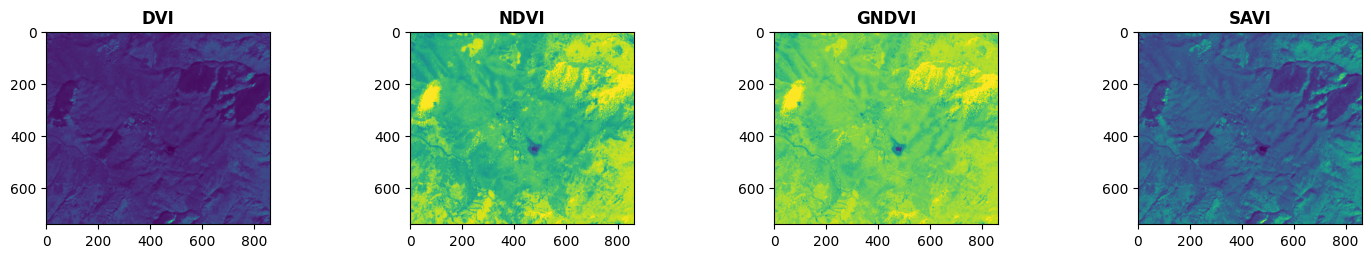

In [359]:
import spyndex 
import rasterio as rio
from glob import glob

tiff = glob('data/*/response.tiff')[0]

ds = rio.open(tiff)

# Scale the data (remember that the valid domain for reflectance is [0,1])
N = ds.read(3)/10000
R = ds.read(2)/10000
G = ds.read(1)/10000

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = ["DVI", "NDVI", "GNDVI", "SAVI"],
    params = {
        "N": N,
        "R": R,
        "G": G,
        "L": 0.5
    }
)

# Plot the indices
fig, ax = plt.subplots(1, 4, figsize = (18,2.5))

rio.plot.show(idx[0], ax=ax[0], cmap='viridis', title='DVI')
rio.plot.show(idx[1], ax=ax[1], cmap='viridis', title='NDVI')
rio.plot.show(idx[2], ax=ax[2], cmap='viridis', title='GNDVI')
rio.plot.show(idx[3], ax=ax[3], cmap='viridis', title='SAVI')

print(idx[0])

It seems to be some differences in the DVI and SAVI visualization results between approaches, although the array values seem identical. We should look into this carefully.

### Water indices

In this use case we are going to compute the NDCI index, which is a water index. The area of interest is the [Aigüestortes i Estany de Sant Maurici National Park](https://en.wikipedia.org/wiki/Aig%C3%BCestortes_i_Estany_de_Sant_Maurici_National_Park).

In [360]:
print(spyndex.indices.NDCI)

NDCI: Normalized Difference Chlorophyll Index
        * Application Domain: water
        * Bands/Parameters: ['RE1', 'R']
        * Formula: (RE1-R)/(RE1+R)
        * Reference: https://doi.org/10.1016/j.rse.2011.10.016
        


In [361]:
%%time

time = ('2023-04-01', '2023-04-10')
bounding_box = BBox((0.974866,42.509764,1.03009,42.537982), crs=CRS.WGS84)   # Aigües-tortes

evalscript = """
    //VERSION=3

function setup() {
    return {
    input:  [{
                bands: ["B04","B05"],
                units: "DN"
            }],
    output: { 
        bands: 3, 
        sampleType: "INT16"
        }
    }
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B05]
}
"""

!rm -r data

request = SentinelHubRequest(
        data_folder='data',
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bounding_box,
        size=bbox_to_dimensions(bounding_box, 5),
        config=config
        )

image = request.get_data(save_data=True)[0]
image.shape

CPU times: user 36.8 ms, sys: 23.4 ms, total: 60.2 ms
Wall time: 1.47 s


(605, 922, 3)

Text(0.5, 1.0, 'NDCI')

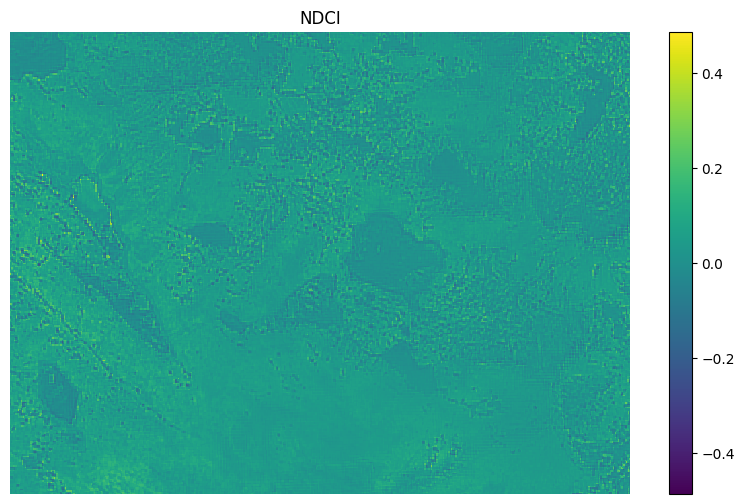

In [362]:
import spyndex 
import rioxarray
from glob import glob

tiff = glob('data/*/response.tiff')[0]

ds = rioxarray.open_rasterio(tiff)

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = "NDCI",
    params = {
        "R": ds.sel(band = 1),
        "RE1": ds.sel(band = 2)
    }
)

# Plot the indices
fig, ax = plt.subplots(1, figsize = (10,6))

idx.plot(ax = ax, cmap='viridis')
ax.set_axis_off()
ax.set_title('NDCI')

## Snow

In this use case we are going to compute the NDSI index, which is a snow index. The area of interest is surrounding [Vielha](https://es.wikipedia.org/wiki/Viella).

In [363]:
print(spyndex.indices.NDSI)

NDSI: Normalized Difference Snow Index
        * Application Domain: snow
        * Bands/Parameters: ['G', 'S1']
        * Formula: (G-S1)/(G+S1)
        * Reference: https://doi.org/10.1109/IGARSS.1994.399618
        


In [364]:
%%time

time = ('2023-01-01', '2023-01-10')
bounding_box = BBox((0.786503,42.730111,0.86329,42.769291), crs=CRS.WGS84)   # Vielha

evalscript = """
    //VERSION=3

function setup() {
    return {
    input:  [{
                bands: ["B03","B11"],
                units: "DN"
            }],
    output: { 
        bands: 3, 
        sampleType: "INT16"
        }
    }
}

function evaluatePixel(sample) {
    return [sample.B03, sample.B11]
}
"""

!rm -r data

request = SentinelHubRequest(
        data_folder='data',
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bounding_box,
        size=bbox_to_dimensions(bounding_box, 5),
        config=config
        )

image = request.get_data(save_data=True)[0]
image.shape

CPU times: user 56.8 ms, sys: 27 ms, total: 83.8 ms
Wall time: 2.14 s


(838, 1279, 3)

Text(0.5, 1.0, 'NDSI')

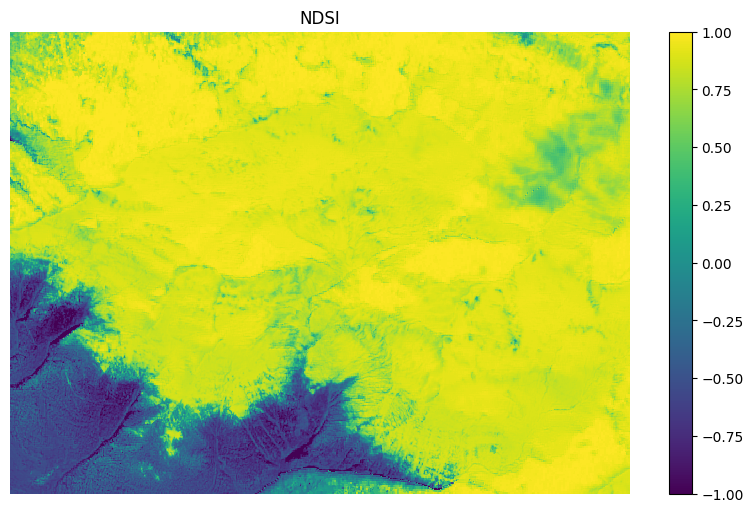

In [365]:
import spyndex 
import rioxarray
from glob import glob

tiff = glob('data/*/response.tiff')[0]

ds = rioxarray.open_rasterio(tiff)

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = "NDSI",
    params = {
        "G": ds.sel(band = 1),
        "S1": ds.sel(band = 2)
    }
)

# Plot the indices
fig, ax = plt.subplots(1, figsize = (10,6))

idx.plot(ax = ax, cmap='viridis')
ax.set_axis_off()
ax.set_title('NDSI')

## Soil

In this use case we are going to compute the BI index, which is a soil index. The area of interest is surrounding [Móra d'Ebre](https://en.wikipedia.org/wiki/M%C3%B3ra_d%27Ebre).

In [366]:
spyndex.indices.BI

SpectralIndex(BI: Bare Soil Index)
        * Application Domain: soil
        * Bands/Parameters: ['S1', 'R', 'N', 'B']
        * Formula: ((S1+R)-(N+B))/((S1+R)+(N+B))
        * Reference: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.465.8749&rep=rep1&type=pdf
        

In [367]:
%%time

time = ('2023-01-01', '2023-01-10')
bounding_box = BBox((0.552374,41.065466,0.678745,41.135955), crs=CRS.WGS84)   # Móra d'Ebre

evalscript = """
    //VERSION=3

function setup() {
    return {
    input:  [{
                bands: ["B02","B04","B08","B11"],
                units: "DN"
            }],
    output: { 
        bands: 4, 
        sampleType: "INT16"
        }
    }
}

function evaluatePixel(sample) {
    return [sample.B02, sample.B04, sample.B08, sample.B11]
}
"""

!rm -r data

request = SentinelHubRequest(
        data_folder='data',
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bounding_box,
        size=bbox_to_dimensions(bounding_box, 5),
        config=config
        )

image = request.get_data(save_data=True)[0]
image.shape

CPU times: user 120 ms, sys: 41.6 ms, total: 162 ms
Wall time: 5.5 s


(1507, 2165, 4)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Text(0.5, 1.0, 'BI')

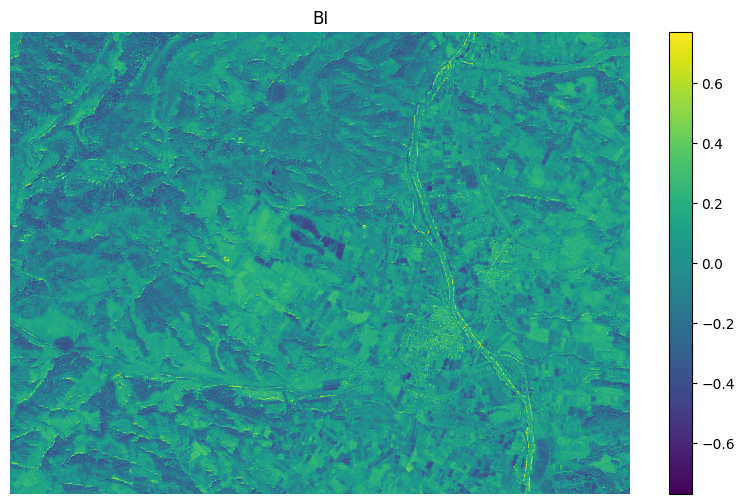

In [368]:
import spyndex 
import rioxarray
from glob import glob

tiff = glob('data/*/response.tiff')[0]

ds = rioxarray.open_rasterio(tiff)

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = "BI",
    params = {
        "B": ds.sel(band = 1),
        "R": ds.sel(band=2),
        "N": ds.sel(band=3),
        "S1": ds.sel(band = 4)
    }
)

# Plot the indices
fig, ax = plt.subplots(1, figsize = (10,6))

idx.plot(ax = ax, cmap='viridis')
ax.set_axis_off()
ax.set_title('BI')